In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from qutip import *
import time
import scipy as sc
import h5py

start_time = time.time()  #checking how long the code takes

erf = sc.special.erf

AL = np.linspace(-2, 2, 50)  #final_disps#the displacements

#for cavity
cdim = 10
c = destroy(cdim)

#for qubit
qdim = 2
u_g = basis(qdim, 0)
u_e = fock(2,1)
q = u_g * u_e.dag()
qd = q.dag()
Ry = Qobj([[1, -1], [1, 1]] / np.sqrt(2))

#qubit-cavity
Q = tensor(destroy(qdim), qeye(cdim))
C = tensor(qeye(qdim), destroy(cdim))
Cd, Qd = C.dag(), Q.dag()

#parameters
chi = 1.359e6  #in Hz
Kerr = 6e3  #in Hz
T1 = 84e-6  #in s
T2 = 21e-6  #in s
Tphi = - 1 / (1 / 2 / T1 - 1 / T2)  #in s
cavT1 = 1.21e-3  #in s
nbar_cav = 0  #initial mean excitation of cavity
nbar_qb = 0  #initial mean excitation of qubit

#dispersive Hamiltonian
H_dis = -2 * np.pi * chi * Cd * C * Qd * Q + 2 * np.pi * Kerr / 2 * Cd * Cd * C * C
Td = 2.84e-7  #wait time in s 
tlist2 = np.linspace(0, Td, 11)

#for Ry(pi/2) pulses
sigma, chop = [16e-9, 4]
#calibration
if 1:
    '''
    Power Rabi: Use this to calibrate the amplitude needed to drive a qubit pi pulse
    '''
    amp = np.linspace(0, 1.5, 199)
    output = []

    for Ax in amp:
        A = np.sqrt(2 / np.pi) / erf(np.sqrt(2)) * np.pi / (4 * sigma) / 2 / np.pi  #initial guess
        A0 = A  #keep it for later

        freq = 0  #resonant driving

        A *= Ax  #coefficient for the Gaussian pulse

        H0 = 2 * np.pi * freq * qd * q
        Hd = 2 * np.pi * A * 1j * (qd - q)  #or with other part Hd = 2*np.pi*A*(qd + q)


        def pulse(t, *arg):
            global sigma, chop
            t0 = sigma * chop / 2

            g = np.exp(- 1 / 2 * (t - t0) ** 2 / sigma ** 2)

            return g


        H = [H0, [Hd, pulse]]

        #initial state
        # psi = basis(2, 0)
        rhoq = thermal_dm(qdim, nbar_qb)  #ket2dm(psi)

        tlist = np.linspace(0, sigma * chop, 100)  #in ns

        c_ops = [
            np.sqrt((1 + nbar_qb) / T1) * q,
            np.sqrt(nbar_qb / T1) * qd,
            np.sqrt(2 / Tphi) * qd * q  #changed
        ]

        e_ops = [qd * q, ]

        # options = Options(max_step = 1, nsteps = 1e6)

        results = mesolve(H, rhoq, tlist, c_ops=c_ops, e_ops=e_ops)  #, options= options)#, progress_bar = True)

        output += [results.expect[0][-1], ]

    # for checking
    # plt.plot(amp, output)
    # plt.ylabel(r"pe")
    # plt.xlabel("Amplitude Scale")
    # plt.title("Power Rabi")
    # plt.grid()
    # plt.show()

    # Hd = 2*np.pi*A*1j*(qd - q)
    # H = [H0, [Hd, pulse]]
    # results = mesolve(H, rho, tlist, c_ops= c_ops)
    # print(results.states[-1])

    #print(max(output), output.index(max(output)), amp[output.index(max(output))])
    A = A0 * amp[output.index(max(output))]  #this is the correct coeff



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002298BACFB50>>
Traceback (most recent call last):
  File "C:\Users\phant\PycharmProjects\qced-encoding\.venv2\Lib\site-packages\ipykernel\ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [104]:
def pulse2(t, *args):
    global sigma, chop
    if t <= sigma*chop:
        t0 = sigma * chop / 2
        g = np.exp(- 1 / 2 * (t - t0) ** 2 / sigma ** 2)
        return g
    elif t <= Td + sigma*chop:
        return 0
    else:
        t0 = sigma * chop * 3/2 + Td
        g = np.exp(- 1 / 2 * (t - t0) ** 2 / sigma ** 2)
        return g
Hd = 2 * np.pi * A * 1j * (Qd - Q) / 2  #1/2 factor for Ry(pi/2)
H = [H_dis * 1, [Hd, pulse2]]
#jump operators qubit-cavity
c_ops = [
    # Qubit Relaxation
    np.sqrt((1 + nbar_qb) / T1) * Q,
    # Qubit Thermal Excitations
    np.sqrt(nbar_qb / T1) * Qd,
    # Qubit Dephasing, changed
    np.sqrt(2 / Tphi) * Qd * Q,
    # Cavity Relaxation
    np.sqrt((1 + nbar_cav) / cavT1) * C,
    # Cavity Thermal Excitations
    np.sqrt(nbar_cav / cavT1) * Cd,
]
#the displacement + parity measurement sequence
par_rand = np.zeros(len(AL))  #store parity
par = np.zeros(len(AL))
#rho_tar is state before displacement + parity measurement
rho_tar = tensor(thermal_dm(qdim, nbar_qb), thermal_dm(cdim, nbar_cav))
rho_rand = tensor(fock_dm(2,0), rand_dm(cdim, pure=True))
for i in np.arange(len(AL)):
    #displace the cavity
    bet = AL[i]
    Ds = displace(cdim, bet)
    rho_cq = tensor(qeye(qdim), Ds).dag() * rho_tar * tensor(qeye(qdim), Ds)
    rho_cq_rand = tensor(qeye(qdim), Ds).dag() * rho_rand * tensor(qeye(qdim), Ds)
    #now the parity sequence
    #first pi/2
    result1 = mesolve(H, rho_cq, [0, sigma*chop*2+Td], c_ops)
    rho_cqt = result1.states[-1]
    q = tensor(destroy(2), qeye(cdim))
    r = mesolve(H, rho_cq_rand, [0, sigma*chop*2+Td], c_ops, options=Options(nsteps=2000),e_ops=[q.dag()*q]).expect[0][-1]
    
    rho_qt = rho_cqt.ptrace([0])
    par[i] = (2 * (rho_qt * (u_e * u_e.dag())).tr() - 1).real
    par_rand[i] = (2 * r - 1).real

print("")
print("--- %s seconds ---" % (time.time() - start_time))


--- 285.3463439941406 seconds ---


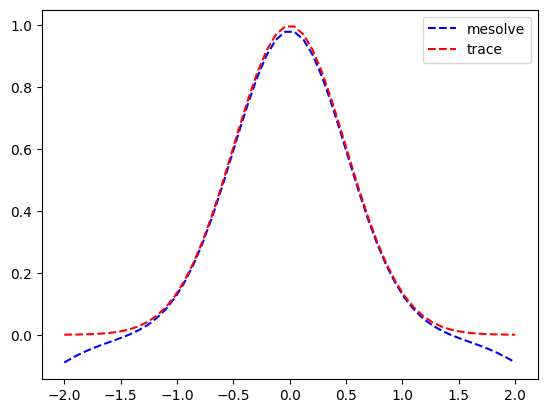

In [105]:
pid = par * 0
P = (1j * np.pi * c.dag() * c).expm()
for j in range(len(AL)):
    t = tensor(qeye(2), displace(cdim, AL[j]))
    r = t.dag() * rho_tar * t
    pid[j] = (P * r.ptrace(1)).tr().real

plt.plot(AL, par, 'b--')
plt.plot(AL, pid, 'r--')
plt.legend(["mesolve", "trace"])

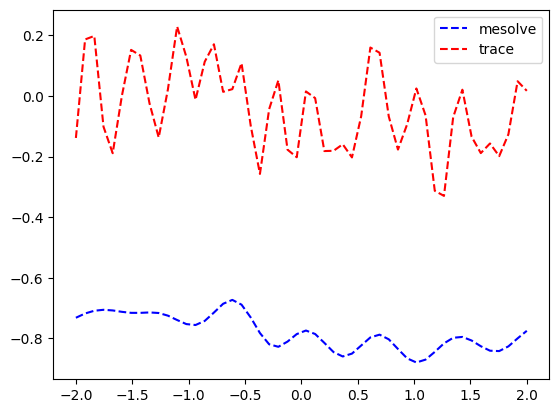

In [106]:
pid_rand = par * 0
P = (1j * np.pi * c.dag() * c).expm()
for j in range(len(AL)):
    t = tensor(qeye(2), displace(cdim, AL[j]))
    r = t.dag() * rho_rand * t
    pid_rand[j] = (P * r.ptrace(1)).tr().real

plt.plot(AL, par_rand, 'b--')
plt.plot(AL, pid_rand, 'r--')
plt.legend(["mesolve", "trace"])